In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import sklearn.preprocessing as preprocessing

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pylab as plt
from keras.utils import np_utils 
import tensorflow as tf

from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.kernel_approximation import Nystroem 
from tpot.builtins import StackingEstimator

from sklearn.metrics import confusion_matrix
import itertools


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"
source_path = "I:\\Honours-Project\\data\\sorted\\agg\\cropped\\"
csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [3]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [4]:
df = df[df['name'].str.contains("_flipped")]

In [5]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(df.groupby('flow_rate').size())

flow_rate
1800    58
3600    58
7200    58
dtype: int64


In [6]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks
46,138_flipped,2017.11.23,1800,34.00 s.tifheightmap.mat,7.487762,3283,14091.628528,0.805744,1,0.606279,4.292302,[[3.28300000e+03 1.53732000e+05 8.86933000e+06...,1.525710,279.580736,[[179.40241225 14.89433452]\r\n [ 14.89433452...,0,1
109,181_flipped,2017.11.23,3600,67.60 s.tifheightmap.mat,14.189006,5465,28115.752514,0.942003,1,0.433991,5.130612,[[5.48000000e+03 4.82574000e+05 5.91854120e+07...,-1.544219,559.386868,[[ 345.14169505 -71.83803899]\r\n [ -71.83803...,0,1
103,34_flipped,2017.11.17,3600,12.85 s.tifheightmap.mat,23.329527,3981,49589.325857,0.953674,1,0.723818,12.456500,[[3.98100000e+03 2.24102000e+05 1.70330560e+07...,-1.444008,303.338095,[[ 118.29187371 -128.46414112]\r\n [-128.46414...,0,1
33,147_flipped,2017.11.23,1800,63.20 s.tifheightmap.mat,12.072265,8282,38567.003117,0.665112,1,0.440157,4.656726,[[8.28200000e+03 6.57899000e+05 5.97043750e+07...,0.125077,653.043723,[[1580.9706008 87.16727495]\r\n [ 87.16727...,0,1
118,52_flipped,2017.11.17,7200,1.90 s.tifheightmap.mat,7.665951,1655,6732.873700,0.948445,1,0.757055,3.921301,[[1.71700000e+03 7.67380000e+04 4.19110800e+06...,-1.495170,197.396970,[[ 47.06751865 -30.20988715]\r\n [-30.20988715...,2,1


In [7]:
nb_classes = 3

In [8]:
x = []
y = []

df['log_volume'] = df['volume'].apply(np.log)

mat = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = mat.drop(columns=['cluster'])

X = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

y = df["flow_rate"].values

y[y == 1800] = 0
y[y == 3600] = 1
y[y == 7200] = 2

one_hot = np_utils.to_categorical(df["flow_rate"].values, nb_classes)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot, test_size=36, stratify=y)

We add the flip of each image to the split dataset. Therefore, there is no information transfer between test and training sets. To Do.

In [10]:
num_samples = X_train.shape[0]
num_features = X_train.shape[1]

num_classes = y_train.shape[1]
#Orientation column
oc = 5

print(X_train.shape)

for i in range(X_train.shape[0]):
    sample = X_train[i]
    flipped_sample = sample.copy()
    flipped_sample[oc] = 0 - sample[oc]
    flipped_sample = flipped_sample.reshape((1,num_features))
    X_train = np.concatenate((X_train, flipped_sample))
    y_train = np.concatenate((y_train, y_train[i].copy().reshape(1, num_classes)))
    
for i in range(X_test.shape[0]):
    sample = X_test[i]
    flipped_sample = sample.copy()
    flipped_sample[oc] = 0 - sample[oc]
    flipped_sample = flipped_sample.reshape((1,num_features))
    X_test = np.concatenate((X_test, flipped_sample))
    y_test = np.concatenate((y_test, y_test[i].copy().reshape(1, num_classes)))

(138, 11)


## sklearn Gradiant Boosted Forest

In [11]:
rfc = RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.1, 
                       min_samples_leaf=4, min_samples_split=9, n_estimators=100)

In [12]:
n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

i = 0

for train, test in skf.split(X,y):
    print("Running Fold", i+1, "/", n_folds)
    i+=1
    
    std = np.std(X[train],0)
    mean = np.mean(X[train],0)
            
    X_train = (X[train] - mean)/std
    X_test = (X[test] - mean)/std 
        
    y_train = y[train]
            
    model = None # Clearing the NN.
    
    # Score on the training set was:0.4762962962962963
    model = make_pipeline(
        FastICA(tol=0.65),
        RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.4, n_estimators=100), step=0.7500000000000001),
        FastICA(tol=0.2),
        Nystroem(gamma=0.45, kernel="polynomial", n_components=6),
        LinearSVC(C=20.0, dual=True, loss="hinge", penalty="l2", tol=0.01)
    )

    # Hyperparameters copied from Random Forest
    # model = GradientBoostingClassifier(max_features=0.1, 
                # min_samples_leaf=4, min_samples_split=9, n_estimators=100, verbose=1)
    
    model.fit(X_train, y_train)
            
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    # Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = y[test]
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred)
    
    print("Accuracy: ", sum(Y_pred == Y_true)/len(Y_true))

Running Fold 1 / 10
Accuracy:  0.4444444444444444
Running Fold 2 / 10
Accuracy:  0.3333333333333333
Running Fold 3 / 10
Accuracy:  0.4444444444444444
Running Fold 4 / 10
Accuracy:  0.3333333333333333
Running Fold 5 / 10
Accuracy:  0.2222222222222222
Running Fold 6 / 10
Accuracy:  0.5
Running Fold 7 / 10
Accuracy:  0.4444444444444444
Running Fold 8 / 10
Accuracy:  0.3333333333333333
Running Fold 9 / 10
Accuracy:  0.4
Running Fold 10 / 10
Accuracy:  0.2


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

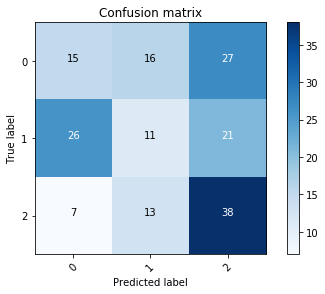

In [14]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 